#  Sequence to Sequence for Machine Translation

In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2060 SUPER


# Loading data files

In [3]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        
        ''' Кол-во обычых токенов '''
        self.n_words = 3

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    ''' Удалите слов ниже определенного порога подсчета '''
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        ''' Повторная инициализация словарей '''
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        
        ''' Кол-во обычых токенов '''
        self.n_words = 3

        for word in keep_words:
            self.index_word(word)

In [4]:
''' Строчные буквы, обрезать и удалить небуквенные символы '''
def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([,.!?])", r"", s)
    return s

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    filename = 'Date/%s-%s.txt' % (lang1, lang2)
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    ''' Разделение строк на пары и нормализация '''
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    ''' Переворот пар, создавание экземпляров класса Lang ''' 
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

In [7]:
filter_pairs_flag = False 

def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print('Read %d sentence pairs' % len(pairs))
    
    if(filter_pairs_flag):
        pairs = filter_pairs(pairs)
    print('Отфильтровано пар: %d' % len(pairs))
    
    print('Индексирование слов...')
    for pair in pairs:
        for u in pair[0].split():
            input_lang.index_word(u)
        for u in pair[1].split():
            output_lang.index_word(u)
    
    print('Индексированных %d слов на входном языке, %d слов на выходном' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('rus', 'oss', True)

Reading lines...
Read 430 sentence pairs
Отфильтровано пар: 430
Индексирование слов...
Индексированных 948 слов на входном языке, 945 слов на выходном


## Фильтрация словарей

In [8]:
''' Минимальное кол-во встречающихся слов, которых стоит оставить '''
MIN_COUNT = 0

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 945 / 945 = 1.0000
keep_words 942 / 942 = 1.0000


## Фильтрация пар

In [9]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    ''' Удаление пар если они не соответствуют условиям ввода и вывода ''' 
    if keep_input and keep_output:
        keep_pairs.append(pair)
        
print("Отброшено %d пар до %d, %.4f от общего числа" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Отброшено 338 пар до 327, 0.9675 от общего числа


## Преобразование обучающих данных в тензоры

In [10]:
''' Возвращает список индексов, по одному для каждого слова в предложении, плюс EOS '''
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [11]:
'''  Заполнение a символом PAD '''
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

In [12]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    '''  Выбирайте случайные пары ''' 
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    ''' Разделение на пары, сортировка по длине (по убыванию), разархивирование '''
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    ''' Для входных и целевых последовательностей получим массив длин и заполните его от 0 до максимальной длины '''
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    ''' Превратим дополненные массивы в тензоры (batch_size x max_len), транспонировать в (max_len x batch_size) '''
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    input_var = input_var.to(device)
    target_var = target_var.to(device)
        
    return input_var, input_lengths, target_var, target_lengths

In [13]:
random_batch(2)

(tensor([[312,  61],
         [295,  62],
         [313, 341],
         [314, 804],
         [295,   2],
         [315,   0],
         [267,   0],
         [316,   0],
         [155,   0],
         [317,   0],
         [  2,   0]], device='cuda:0'),
 [11, 5],
 tensor([[332,  23],
         [333, 794],
         [328, 914],
         [334,   2],
         [301,   0],
         [335,   0],
         [336,   0],
         [337,   0],
         [338,   0],
         [301,   0],
         [  2,   0]], device='cuda:0'),
 [11, 4])

# Построение моделей

## Encoder

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Примечание: мы запускаем все это одновременно (в нескольких пакетах из нескольких последовательностей)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        return outputs, hidden

## Attention Decoder

In [15]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Создаем переменную для хранения энергии внимания
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        attn_energies = attn_energies.to(device)
        
        # Для каждой партии выходов encoder'а
        for b in range(this_batch_size):
            # Вычисляет энергию для каждого выходного сигнала encoder'а
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Нормализуйте энергии до весов в диапазоне от 0 до 1, измените размер до 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

In [16]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Определение параметров
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Определение слоев
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attention('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Получяем вложение текущего входного слова (последнее выходное слово)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S = 1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Вычислите веса внимания и примените их к выходам encoder'а
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Объединяем встроенное входное слово и посещаемый контекст, запустив через RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Конечный выходной слой
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Возвращаем конечный результат, скрытое состояние и веса внимания (для визуализации)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Сохранение для справки
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Определение слоев
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Выбор модели внимания
        if attn_model != 'none':
            self.attn = Attention(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):

        # Получаем вложение текущего входного слова (последнее выходное слово)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Получаем текущее скрытое состояние из входного слова и последнее скрытое состояние
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Вычисление внимание по текущему состоянию RNN и всем выходам  encoder'а
        # Примение к выходам encoder'а для получения средневзвешенного значения
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Вектор внимания с использованием скрытого состояния RNN и вектора контекста
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        output = self.out(concat_output)

        # Возвращение конечного результата, скрытого состояния и веса внимания (для визуализации)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Тестирование моделей

In [18]:
small_batch_size = 2
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([5, 2])
target_batches torch.Size([5, 2])


In [19]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

print(encoder_test.to(device))
print(decoder_test.to(device))

EncoderRNN(
  (embedding): Embedding(957, 8)
  (gru): GRU(8, 8, num_layers=2, dropout=0.1, bidirectional=True)
)
LuongAttnDecoderRNN(
  (embedding): Embedding(1055, 8)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(8, 8, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=1055, bias=True)
  (attn): Attention(
    (attn): Linear(in_features=8, out_features=8, bias=True)
  )
)


In [20]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hid

encoder_outputs torch.Size([5, 2, 8])
encoder_hidden torch.Size([4, 2, 8])


In [21]:
max_target_length = max(target_lengths)

# Подготовка входных и выходных данных декодера
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))

# Использовать последнее (прямое) скрытое состояние от кодировщика
decoder_hidden = encoder_hidden[:decoder_test.n_layers]
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

all_decoder_outputs = all_decoder_outputs.to(device)
decoder_input = decoder_input.to(device)

# Прогоняет декодер по одному временному шагу за раз
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    
    # Сохранить результаты этого шага
    all_decoder_outputs[t] = decoder_output
    # Следующий ввод - текущая цель
    decoder_input = target_batches[t]

# Тест замаскированной потери перекрестной энтропии
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)

print('loss', loss.data.tolist())

loss 7.174855709075928


C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_15556/2607085294.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(1)
D:\Programms\Anaconda\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Onigatari\Desktop\Graduate-Work\Notebook\masked_cross_entropy.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_flat = functional.log_softmax(logits_flat)
C:\Users\Onigatari\Desktop\Graduate-Work\Notebook\masked_cross_entropy.py:9: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end)

# Training

In [22]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    decoder_input = decoder_input.to(device)
    all_decoder_outputs = all_decoder_outputs.to(device)

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data.tolist(), ec, dc

# Running training

In [23]:
# Configure models
attn_model = 'concat'
hidden_size = 256
n_layers = 2
dropout = 0.1
batch_size = 100
batch_size = 50

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 500
epoch = 0
plot_every = 20
print_every = 100
evaluate_every = 1000

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
encoder.to(device)
decoder.to(device)

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [24]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

# Evaluating the network

In [25]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    
    input_batches = input_batches.to(device)
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    
    decoder_input = decoder_input.to(device)

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        decoder_input = decoder_input.to(device)

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [26]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# Visualizing attention

In [27]:
import io
import torchvision
from PIL import Image
# import visdom
# vis = visdom.Visdom()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

In [28]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [29]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    # vis.text(text, win=win, opts={'title': win})

# Putting it all together

In [30]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    
    # job.record(epoch, loss)
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

#     if epoch % plot_every == 0:
#         plot_loss_avg = plot_loss_total / plot_every
#         plot_losses.append(plot_loss_avg)
#         plot_loss_total = 0
        
#         # TODO: Running average helper
#         ecs.append(eca / plot_every)
#         dcs.append(dca / plot_every)
#         ecs_win = 'encoder grad (%s)' % hostname
#         dcs_win = 'decoder grad (%s)' % hostname
#         vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
#         vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
#         eca = 0
#         dca = 0

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_15556/2607085294.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(1)
D:\Programms\Anaconda\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Onigatari\Desktop\Graduate-Work\Notebook\masked_cross_entropy.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_flat = functional.log_softmax(logits_flat)
C:\Users\Onigatari\Desktop\Graduate-Work\Notebook\masked_cross_entropy.py:9: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

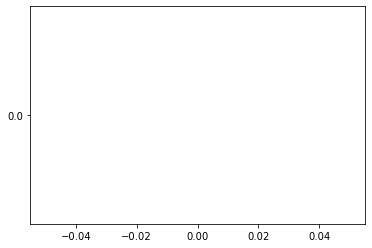

In [33]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [34]:
evaluate_randomly()

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_8224/2192798142.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)


RuntimeError: shape '[13, 1, 1000]' is invalid for input of size 3000